In [1]:
import sys

In [2]:
!conda install --yes --prefix {sys.prefix} tensorflow

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.5.2
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.9.0




In [3]:
import numpy as np
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("age_gender.csv")

In [5]:
df

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


In [7]:
df = df.drop('ethnicity',axis=1)

<Axes: xlabel='age', ylabel='Density'>

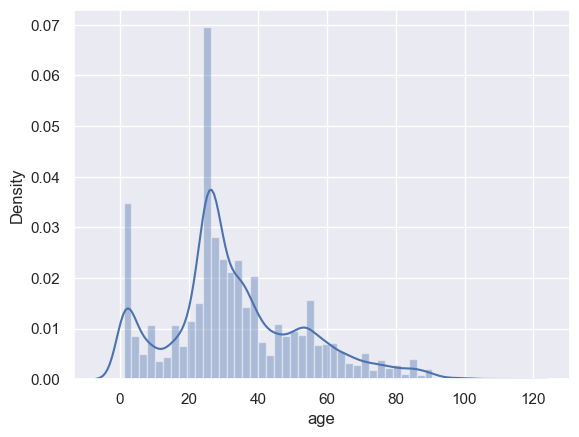

In [8]:
import seaborn as sns
sns.distplot(df['age'])

In [9]:
def convert_pixels(x):
    return np.array(x.split(' '), dtype=np.float32).reshape(48, 48)

df['pixels'] = df['pixels'].map(convert_pixels)

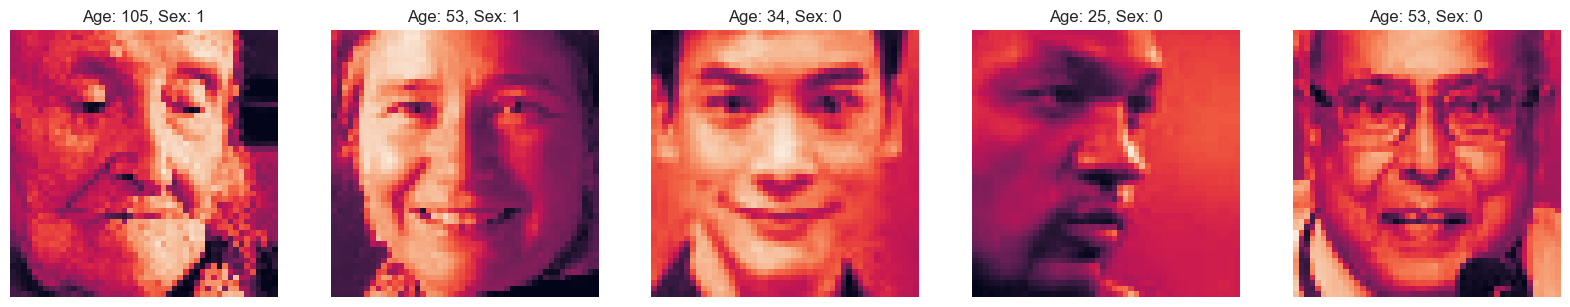

In [10]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))

    age = df['age'][random_face]
    gender = df['gender'][random_face]

    axes[i].set_title('Age: {0}, Sex: {1}'.format(age, gender))
    axes[i].imshow(df['pixels'][random_face])
    axes[i].axis('off')

In [11]:
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)
if np.max(X_reshaped) > 1:
     X_reshaped = X_reshaped / 255

In [12]:
input_shape = X_reshaped.shape[1:]

n_epochs = 15
batch_size = 64
y = df['age'].values

## age model development

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2,random_state=42) 

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.5))
age_model.add(BatchNormalization())

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1))

age_model.compile(optimizer='adam', loss='mse')

age_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

In [15]:
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'),
             ReduceLROnPlateau(patience=2, verbose=1)]

In [ ]:
history = age_model.fit(X_train, y_train,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/15
297/297 [==============================] - 92s 299ms/step - loss: 310.4029 - val_loss: 1702.6348 - lr: 0.0010
Epoch 2/15
297/297 [==============================] - 74s 249ms/step - loss: 153.4361 - val_loss: 2019.6094 - lr: 0.0010
Epoch 3/15
297/297 [==============================] - 76s 255ms/step - loss: 132.6306 - val_loss: 111.3142 - lr: 0.0010
Epoch 4/15
297/297 [==============================] - 72s 242ms/step - loss: 122.7205 - val_loss: 191.9424 - lr: 0.0010
Epoch 5/15
297/297 [==============================] - ETA: 0s - loss: 115.6682
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
297/297 [==============================] - 73s 247ms/step - loss: 115.6682 - val_loss: 117.8037 - lr: 0.0010
Epoch 6/15
297/297 [==============================] - 71s 240ms/step - loss: 101.5062 - val_loss: 86.0498 - lr: 1.0000e-04
Epoch 7/15
297/297 [==============================] - 71s 240ms/step - loss: 96.6998 - val_loss: 84.5527 - lr: 1.0000e-04
Epoch 8/

In [ ]:
pd.DataFrame(history.history).plot();

In [ ]:
y_pred = age_model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, y_test);

## Gender Model

In [ ]:
y = df['gender'].values
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [ ]:
gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

gender_model.add(Flatten())

gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

gender_model.add(Dense(1, activation='sigmoid')) #For binary classification activation function is sigmoid 

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #...and loss function is binary_crossentropy

gender_model.summary()

In [ ]:
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1)]

In [ ]:
history = gender_model.fit(X_train, y_train, 
                           epochs=n_epochs,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

In [ ]:
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
y_pred = (gender_model.predict(X_test) > 0.5).astype("int32")

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');

In [ ]:
y_pred = y_pred.reshape(y_pred.shape[0])
X_fp = X_test[(y_pred == 1) & (y_test == 0)] 

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    
    random_choice = np.random.choice(len(X_fp))
    
    axes[i].imshow(X_fp[random_choice].reshape(48, 48))
    axes[i].axis('off')

In [ ]:
X_fn = X_test[(y_pred == 0) & (y_test == 1)]  

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    
    random_choice = np.random.choice(len(X_fn))
    axes[i].imshow(X_fn[random_choice].reshape(48, 48))
    axes[i].axis('off')

In [ ]:
def face_prediction(image):
    x = image.reshape(1, 48, 48, 1)
    x = x / 255
    age_predict = int(age_model.predict(x))
    gender_predict = int(gender_model.predict_classes(x))
    gender = {0: 'Male', 1: 'Female'}    
    plt.imshow(image)
    plt.title('{0}, {1}'.format(age_predict, gender[gender_predict]))
    plt.axis('off')


## Final testing

In [ ]:
random_face = np.random.choice(len(df))

age = df['age'][random_face]
gender = df['gender'][random_face]

plt.imshow(df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}'.format(age, gender))
plt.axis('off');


In [ ]:
random_face = np.random.choice(len(df))

age = df['age'][random_face]
gender = df['gender'][random_face]

plt.imshow(df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}'.format(age, gender))
plt.axis('off');

In [ ]:
random_face = np.random.choice(len(df))

age = df['age'][random_face]
gender = df['gender'][random_face]

plt.imshow(df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}'.format(age, gender))
plt.axis('off');